In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pycountry
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import preprocess as pre

In [2]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

/Users/milesli/Desktop/Age-Based-Personalised-Books-Recommendation-System/Report&Coding/data&code/preprocess.py:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Book-Author"].fillna("NO AUTHOR", inplace=True)


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,93450,topeka,kansas,united states,5.0,0-10,0836213122,10,there's treasure everywhere--a calvin and hobb...,bill watterson,1996,andrews mcmeel publishing,high
1,52752,ridgewood,new york,united states,5.0,0-10,0060502258,10,the divine secrets of the ya-ya sisterhood: a ...,rebecca wells,2002,harpertorch,high
2,155127,orlando,florida,united states,5.0,0-10,055356921X,5,the strange files of fremont jones (fremont jo...,dianne day,1996,bantam,medium
3,172713,bronx,new york,united states,5.0,0-10,0380727668,10,live from death row,mumia abu-jamal,1996,perennial,high
4,172713,bronx,new york,united states,5.0,0-10,038082101X,5,daughter of fortune: a novel,isabel allende,2001,harpertorch,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,114865,croydon,victoria,australia,97.0,90-100,0553271067,10,passages: predictable crises of adult life,gail sheehy,1984,bantam,high
204160,114865,croydon,victoria,australia,97.0,90-100,0749309423,9,the silence of the lambs,thomas harris,1991,mandarin,high
204161,228990,private,michigan,united states,99.0,90-100,0425122123,7,clear and present danger (jack ryan novels),tom clancy,1996,berkley publishing group,high
204162,228990,private,michigan,united states,99.0,90-100,044022165X,8,the rainmaker,john grisham,1996,dell,high


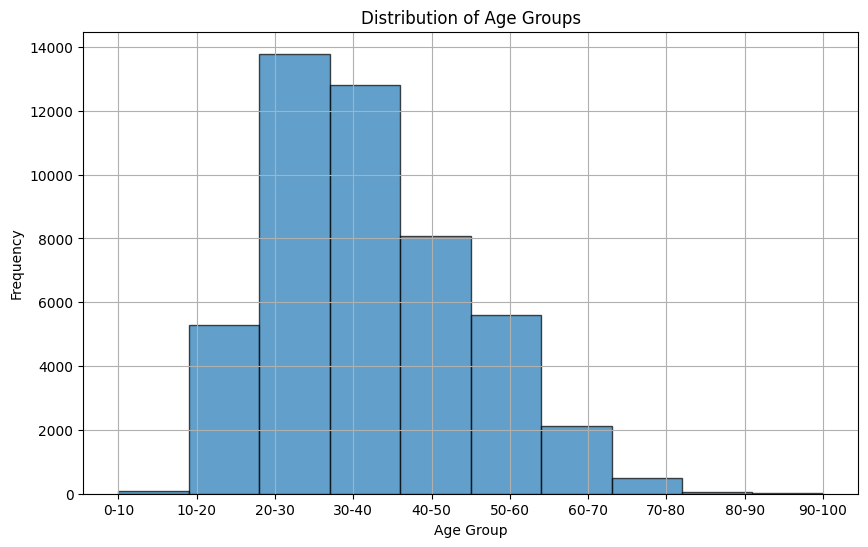

In [3]:
users_df = pd.read_csv(users_file)
ratings_df = pd.read_csv(rating_file)
books_df = pd.read_csv(books_file)

# Imputation missing data and discretise the age based on an age group
users_df = pre.ages_imputation(pre.weighted_age_dict(users_file), users_df)
users_df = pre.city_imputation(users_df)
users_df = pre.state_imputation(users_df)
users_df = pre.country_imputation(users_df)
merged_df = pre.discretising(users_df, ratings_df, books_df)
merged_df = pre.author_imputation(merged_df)
merged_df = pre.text_process(merged_df)
merged_df.to_csv("merge.csv", index=False)

merged_df

Get books names and book ratings

In [4]:
books_rating_df = merged_df[["ISBN", "Book-Title", "Book-Rating"]]
average_ratings = (books_rating_df.groupby(["ISBN", "Book-Title"])["Book-Rating"].mean().reset_index())
books_rating_df = average_ratings.drop_duplicates(subset=["Book-Title"])
rate_bins = [0, 4, 7, 11]
rate_labels = ["low", "medium", "high"]
books_rating_df["Rating_Category"] = pd.cut(
        books_rating_df["Book-Rating"], bins=rate_bins, labels=rate_labels, right=False
    )
books_rating_df

/var/folders/mq/6q50mgjd1d153dnsb6hrtlk40000gn/T/ipykernel_93876/4190279325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_rating_df["Rating_Category"] = pd.cut(


,ISBN,Book-Title,Book-Rating,Rating_Category
0,0002005018,clara callan,7.500000,high
1,0002116286,there's a seal in my sleeping bag,7.250000,high
2,0002243962,girlfriend in a coma,5.750000,medium
3,0002251760,the forgetting room: a fiction (byzantium book),8.833333,high
4,0002255081,spadework,6.250000,medium
...,...,...,...,...
18180,9722105248,o evangelho segundo jesus cristo: romance,8.400000,high
18181,9726101794,as mulheres deviam vir com livro de instruãâ§...,6.000000,medium
18182,9728423160,nos teus braãâ§os morrerãâ­amos: ficãâ§ãâ£o,7.000000,high
18183,9812327975,notes from an even smaller island,8.000000,high


# For Test Set

/Users/milesli/Desktop/Age-Based-Personalised-Books-Recommendation-System/Report&Coding/data&code/preprocess.py:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Book-Author"].fillna("NO AUTHOR", inplace=True)


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Rating_Category
0,30263,traverse city,michigan,united states,5.0,0-10,0758203004,9,circle of five,dolores stewart riccio,2003,kensington publishing corporation,high
1,120598,plant city,florida,united states,5.0,0-10,0385472560,8,the fifth discipline fieldbook: strategies and...,peter m. senge,1994,currency,high
2,120598,plant city,florida,united states,5.0,0-10,1551666111,6,under the knife,tess gerritsen,2000,mira,medium
3,109405,grebenstein,hessen,germany,5.0,0-10,3257230052,7,ein engel ã?ãâ¼ber deinem grab.,valerie wilson wesley,1998,diogenes verlag,high
4,177157,antelope,california,united states,5.0,0-10,1551669048,8,warrior,elizabeth lowell,2002,mira,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,104404,bonita springs,florida,united states,85.0,80-90,0425197395,6,the mediterranean caper,clive cussler,2004,berkley publishing group,medium
23141,211137,state college,pennsylvania,united states,85.0,80-90,0140322051,8,friedrich (puffin books),hans peter richter,1987,penguin putnam books for young readers,high
23142,225867,despair,indiana,united states,93.0,90-100,0393322432,5,people who knock on the door,patricia highsmith,2001,w.w. norton & company,medium
23143,114865,croydon,victoria,australia,97.0,90-100,0586037950,9,the golden notebook,doris may lessing,1979,granada publishing,high


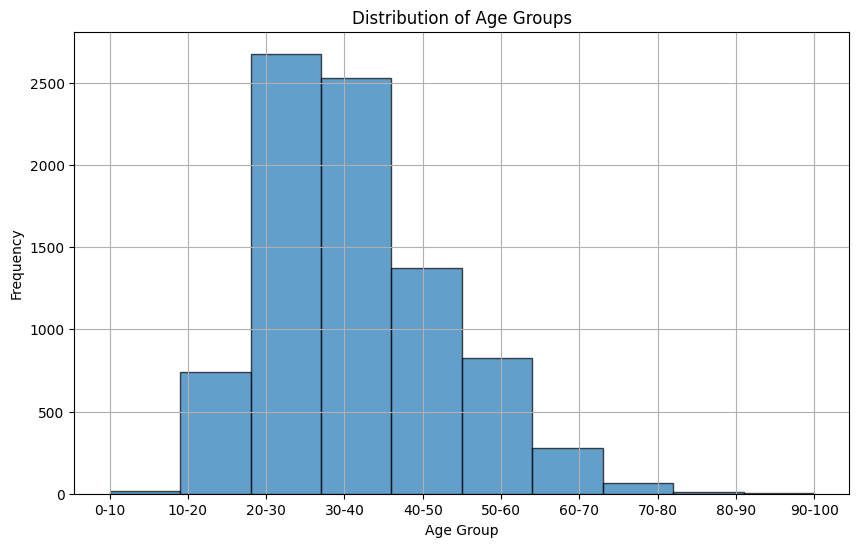

In [6]:
new_users_df = pd.read_csv(new_users_file)
new_ratings_df = pd.read_csv(new_ratings_file)
new_books_df = pd.read_csv(new_books_file)

# Imputation missing data and discretise the age based on an age group
new_users_df = pre.ages_imputation(pre.weighted_age_dict(new_users_file), new_users_df)
new_users_df = pre.city_imputation(new_users_df)
new_users_df = pre.state_imputation(new_users_df)
new_users_df = pre.country_imputation(new_users_df)
test_merged_df = pre.discretising(new_users_df, new_ratings_df, new_books_df)
test_merged_df = pre.author_imputation(test_merged_df)
test_merged_df = pre.text_process(test_merged_df)
test_merged_df

In [7]:
for feature in [
    "User-City",
    "User-State",
    "User-Country",
    "Age-Group",
    "Book-Author",
    "Year-Of-Publication",
    "Book-Publisher",
    "Book-Title"
]:
    print(
        feature,
        pre.compute_information_gain(
            merged_df[feature], merged_df["Rating_Category"]
        ).round(4),
    )

User-City 0.1038
User-State 0.0166
User-Country 0.0021
Age-Group 0.0008
Book-Author 0.0751
Year-Of-Publication 0.0027
Book-Publisher 0.0231
Book-Title 0.1435


In [7]:
# Deleted Features with low IG to train the DT
new_features = [
    "User-City",
    "Book-Author",
    "Book-Title",
]

train_X = OrdinalEncoder().fit_transform(merged_df[new_features])
train_y = OrdinalEncoder().fit_transform(merged_df[["Rating_Category"]])

test_X = OrdinalEncoder().fit_transform(test_merged_df[new_features])
test_y = OrdinalEncoder().fit_transform(test_merged_df[["Rating_Category"]])

# Initialise the DT
dt_classifier = DecisionTreeClassifier(criterion="entropy")

# Train the model
dt_classifier.fit(train_X, train_y)

# Do Cross validation to test the training process
cross_validation = cross_val_score(dt_classifier, train_X, train_y, cv=10)
print("Cross Validation Scores:", cross_validation)
print("Average Score:", np.mean(cross_validation))

pred_y = dt_classifier.predict(test_X)

accuracy = accuracy_score(pred_y, test_y)
print("Final Accuracy:", accuracy)

Cross Validation Scores: [0.66219327 0.64838125 0.66043003 0.66410344 0.64170259 0.64052704
 0.65590713 0.64811912 0.64601293 0.65316418]
Average Score: 0.652054099196717
Final Accuracy: 0.6215597321235689


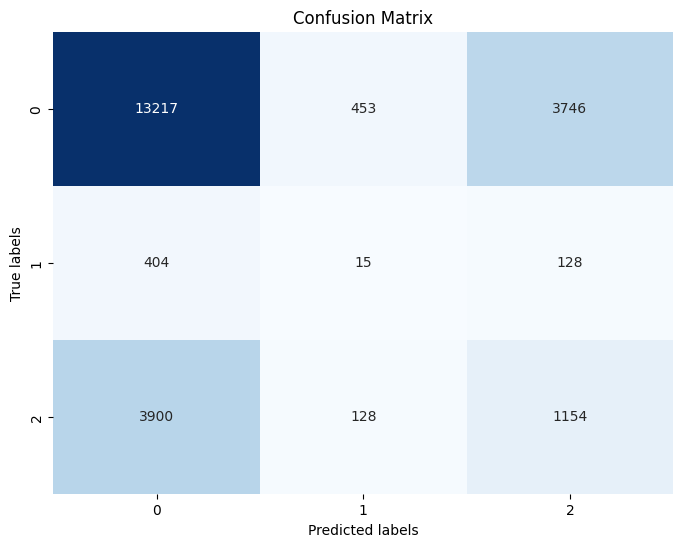

In [8]:
# Confusion matrix
cm = confusion_matrix(test_y, pred_y)

# Visulisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

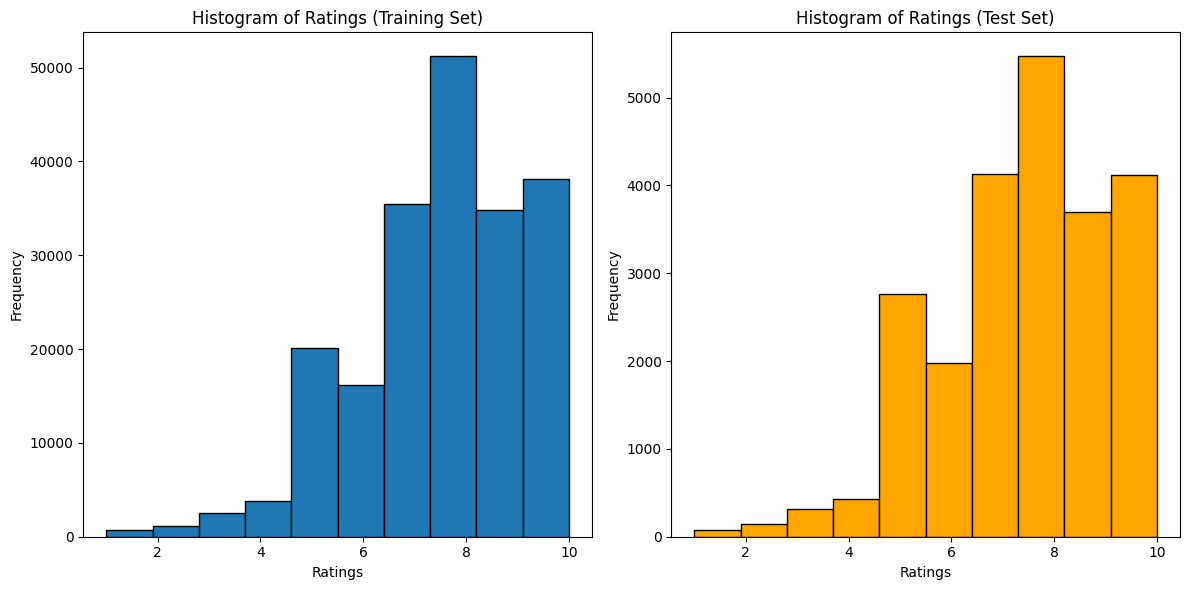

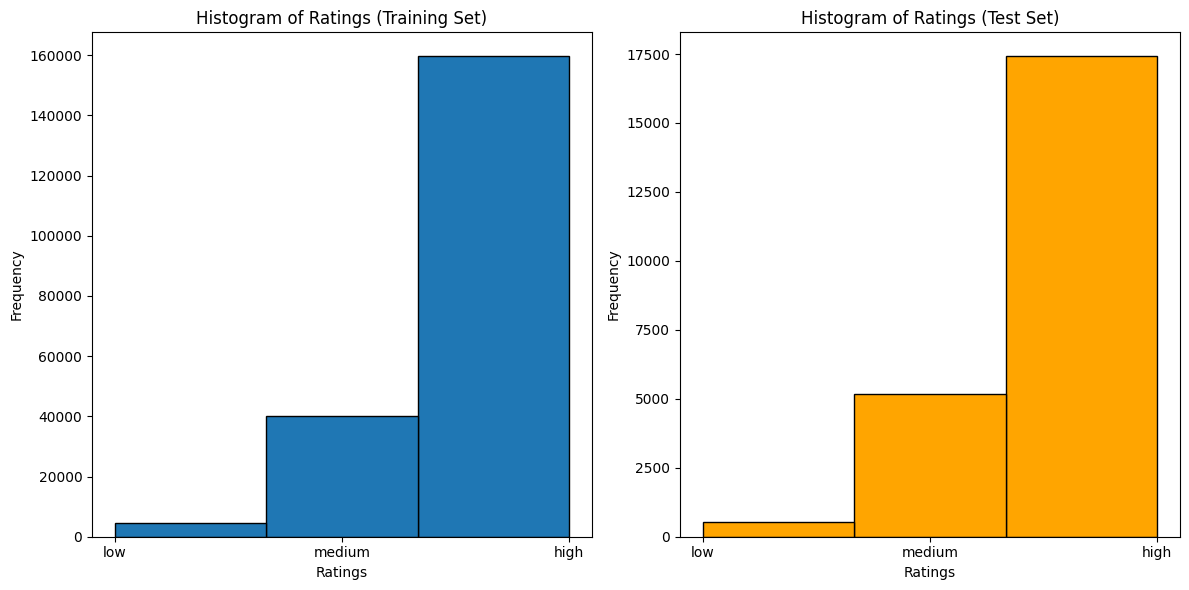

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# For Rating
axs[0].hist(merged_df["Book-Rating"], bins=10, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")

axs[1].hist(test_merged_df["Book-Rating"], bins=10, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")

plt.tight_layout()

# For Rating category
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(merged_df["Rating_Category"], bins=3, edgecolor="black")
axs[0].set_xlabel("Ratings")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of Ratings (Training Set)")
axs[0].invert_xaxis()

axs[1].hist(test_merged_df["Rating_Category"], bins=3, edgecolor="black", color="orange")
axs[1].set_xlabel("Ratings")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Ratings (Test Set)")
axs[1].invert_xaxis()

plt.tight_layout()

## BOW vectors for books' name

In [11]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

book_names = set(merged_df["Book-Title"])

# Preprocessing and tokenization
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and duplicates
    tokens = set([word for word in tokens if word not in stopwords.words('english')])
    return " ".join(tokens)

# Preprocess book names
preprocessed_books = [preprocess_text(book) for book in book_names]

# Creating bag-of-words vectors
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(preprocessed_books)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/skylarhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skylarhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


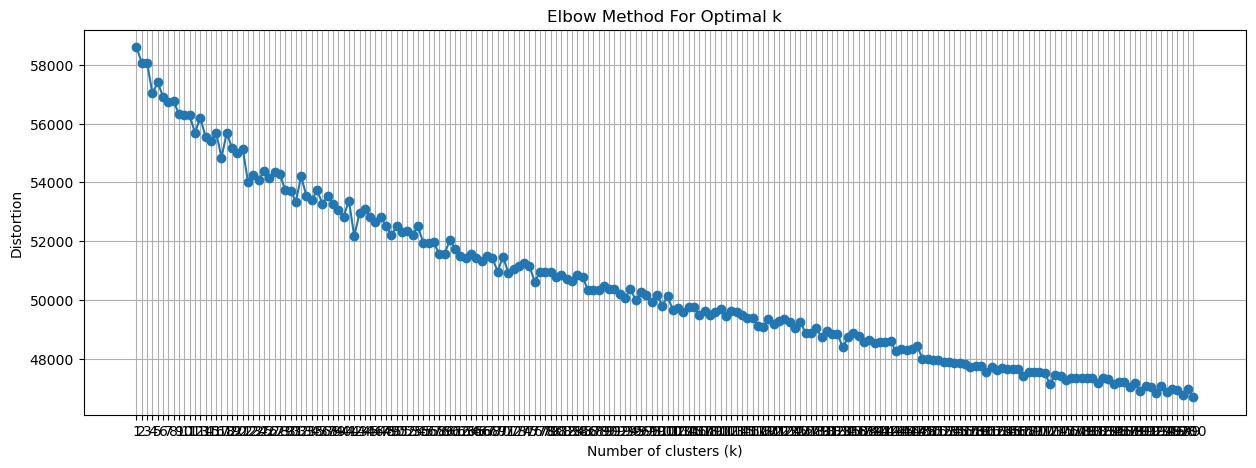

In [21]:
# Calculate distortion for a range of number of cluster
distortions = []
K_range = range(1, 201)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bow_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(15, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [17]:
# Perform K-means clustering
num_clusters = 42  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(bow_matrix)

# Get cluster labels and assign each book to a cluster
cluster_labels = kmeans.labels_
book_clusters = {}
for i, book in enumerate(book_names):
    cluster = cluster_labels[i]
    if cluster not in book_clusters:
        book_clusters[cluster] = []
    book_clusters[cluster].append(book)

# Print out the clusters
for cluster, books in book_clusters.items():
    print(f"Cluster {cluster + 1}:")
    print(len(books))
    '''for book in books:
        print(f"- {book}")'''

# If you are a user, you can input the book's name which you like, 
# it will output a cluster of books which are similar to what you like
def recomend_book_cluster(book_name):
    book_name = str(book_name).lower()
    for cluster_num, books in book_clusters.items():
        if book_name in books:
            return cluster_num
    return -1

# Extract highly rated books
highly_rated_book_clusters = {}

for cluster, books in book_clusters.items():
    highly_rated_books = []
    for book in books:
        book_info = books_rating_df[
            (books_rating_df["Book-Title"] == book)
            & (books_rating_df["Rating_Category"] == "high")
        ]
        if not book_info.empty:
            highly_rated_books.append(book)
    if highly_rated_books:
        highly_rated_book_clusters[cluster] = highly_rated_books

# Print the results
for cluster, books in highly_rated_book_clusters.items():
    print(f"Cluster {cluster + 1} (Highly Rated Books):", len(books))
    print(books)

Cluster 9:
48
Cluster 7:
11640
Cluster 3:
341
Cluster 24:
254
Cluster 41:
94
Cluster 5:
835
Cluster 40:
64
Cluster 13:
131
Cluster 25:
238
Cluster 18:
647
Cluster 12:
155
Cluster 2:
120
Cluster 14:
88
Cluster 6:
116
Cluster 11:
41
Cluster 27:
82
Cluster 39:
5
Cluster 34:
98
Cluster 23:
101
Cluster 38:
94
Cluster 31:
30
Cluster 17:
53
Cluster 21:
107
Cluster 20:
45
Cluster 4:
61
Cluster 15:
127
Cluster 30:
50
Cluster 22:
67
Cluster 19:
18
Cluster 16:
13
Cluster 10:
14
Cluster 29:
76
Cluster 28:
17
Cluster 37:
51
Cluster 8:
10
Cluster 36:
20
Cluster 32:
10
Cluster 33:
7
Cluster 35:
2
Cluster 42:
3
Cluster 1:
2
Cluster 26:
1
Cluster 9 (Highly Rated Books): 32
['star wars: from the adventures of luke skywalker : a novel', 'agents of chaos ii: jedi eclipse (star wars: the new jedi order, book 5)', 'the star wars trilogy: star wars, the empire strikes back, return of the jedi', 'the last command (star wars: the thrawn trilogy, vol. 3)', 'dark tide ii: ruin (star wars: the new jedi order, boo

6